In [1]:
from typing import List, Tuple, Dict, Any, Optional
from pandarallel import pandarallel
import os
import re
import sys
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
# PATH_ITER_1 = "../program_bank/v026_iter_1/2025_02_08__02_10"
PATH_ITER_2 = "../program_bank/v026_iter_2/2025_02_13__17_26"
PATH_ITER_5 = "../program_bank/v026_iter_5/2025_02_13__17_27"
PATH_ITER_10 = "../program_bank/v026_iter_10/2025_02_13__17_27"


def read_metadata(path: str, rounds: int) -> List[Dict[str, Any]]:
    records = []
    file_path = os.path.join(path, "_qite_stats.txt")
    if os.path.exists(file_path):
        with open(file_path, 'r') as file:
            for line in file:
                record = json.loads(line)
                record["number_of_rounds"] = rounds
                if rounds == 10:
                    record["n_initial_programs"] = 1000
                elif rounds == 5:
                    record["n_initial_programs"] = 2000
                elif rounds == 2:
                    record["n_initial_programs"] = 5000
                records.append(record)
    return records


metadata_records = []
# metadata_records.extend(read_metadata(PATH_ITER_1, 1))
metadata_records.extend(read_metadata(PATH_ITER_2, 2))
metadata_records.extend(read_metadata(PATH_ITER_5, 5))
metadata_records.extend(read_metadata(PATH_ITER_10, 10))

metadata_dict = {"records": metadata_records}
metadata_df = pd.DataFrame(metadata_records)
print(metadata_df)

    round  n_program  number_of_rounds  n_initial_programs
0       1       3091                 2                5000
1       2       2722                 2                5000
2       1       1246                 5                2000
3       2       1089                 5                2000
4       3       1054                 5                2000
5       4       1037                 5                2000
6       5       1020                 5                2000
7       1        614                10                1000
8       2        555                10                1000
9       3        542                10                1000
10      4        533                10                1000
11      5        525                10                1000
12      6        514                10                1000
13      7        502                10                1000
14      8        491                10                1000
15      9        475                10                10

    round  n_program  number_of_rounds  n_initial_programs
0       1       3091                 2                5000
1       2       2722                 2                5000
2       1       1246                 5                2000
3       2       1089                 5                2000
4       3       1054                 5                2000
5       4       1037                 5                2000
6       5       1020                 5                2000
7       1        614                10                1000
8       2        555                10                1000
9       3        542                10                1000
10      4        533                10                1000
11      5        525                10                1000
12      6        514                10                1000
13      7        502                10                1000
14      8        491                10                1000
15      9        475                10                10

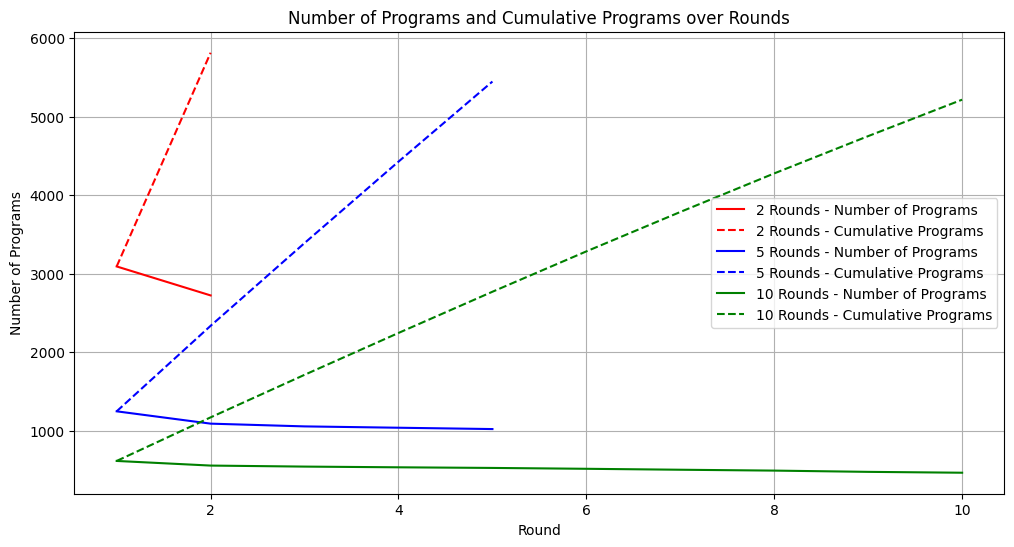

In [3]:
# Settings dictionary
settings = {
    2: {"path": PATH_ITER_2, "n_initial_programs": 5000},
    5: {"path": PATH_ITER_5, "n_initial_programs": 2000},
    10: {"path": PATH_ITER_10, "n_initial_programs": 1000}
}


def read_metadata(path: str, rounds: int, n_initial_programs: int) -> List[Dict[str, Any]]:
    records = []
    file_path = os.path.join(path, "_qite_stats.txt")
    if os.path.exists(file_path):
        with open(file_path, 'r') as file:
            for line in file:
                record = json.loads(line)
                record["number_of_rounds"] = rounds
                record["n_initial_programs"] = n_initial_programs
                records.append(record)
    return records


metadata_records = []
for rounds, setting in settings.items():
    metadata_records.extend(
        read_metadata(
            setting["path"],
            rounds, setting["n_initial_programs"]))

metadata_dict = {"records": metadata_records}
metadata_df = pd.DataFrame(metadata_records)
print(metadata_df)


def filter_and_cumsum(df: pd.DataFrame, rounds: int) -> pd.DataFrame:
    df_filtered = df[df["number_of_rounds"] == rounds].copy()
    df_filtered['cumulative_programs'] = df_filtered['n_program'].cumsum()
    return df_filtered


def plot_programs(
        df_2_rounds: pd.DataFrame, df_5_rounds: pd.DataFrame,
        df_10_rounds: pd.DataFrame) -> None:
    plt.figure(figsize=(12, 6))

    # Plot for 2 rounds
    plt.plot(df_2_rounds['round'], df_2_rounds['n_program'],
             label='2 Rounds - Number of Programs', color='red')
    plt.plot(
        df_2_rounds['round'],
        df_2_rounds['cumulative_programs'],
        label='2 Rounds - Cumulative Programs', color='red', linestyle='--')

    # Plot for 5 rounds
    plt.plot(df_5_rounds['round'], df_5_rounds['n_program'],
             label='5 Rounds - Number of Programs', color='blue')
    plt.plot(
        df_5_rounds['round'],
        df_5_rounds['cumulative_programs'],
        label='5 Rounds - Cumulative Programs', color='blue', linestyle='--')

    # Plot for 10 rounds
    plt.plot(
        df_10_rounds['round'],
        df_10_rounds['n_program'],
        label='10 Rounds - Number of Programs', color='green')
    plt.plot(
        df_10_rounds['round'],
        df_10_rounds['cumulative_programs'],
        label='10 Rounds - Cumulative Programs', color='green', linestyle='--')

    plt.xlabel('Round')
    plt.ylabel('Number of Programs')
    plt.title('Number of Programs and Cumulative Programs over Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()


# Main execution
df = metadata_df.copy()

df_2_rounds = filter_and_cumsum(df, 2)
df_5_rounds = filter_and_cumsum(df, 5)
df_10_rounds = filter_and_cumsum(df, 10)

plot_programs(df_2_rounds, df_5_rounds, df_10_rounds)

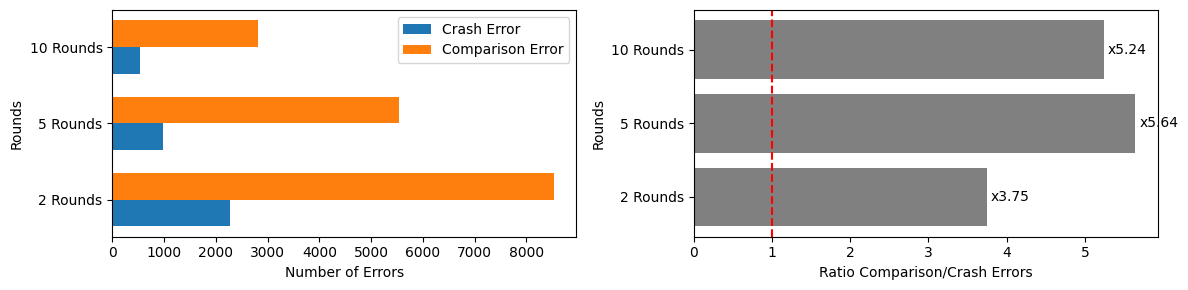

In [12]:
def count_files_in_folder(folder_path: str) -> int:
    if os.path.exists(folder_path):
        return len([name for name in os.listdir(folder_path)
                    if os.path.isfile(os.path.join(folder_path, name))])
    return 0


error_counts = []
comparison_counts = []
labels = []

for rounds, setting in settings.items():
    error_folder = os.path.join(setting["path"], "error")
    comparison_folder = os.path.join(setting["path"], "comparison")

    error_count = count_files_in_folder(error_folder)
    comparison_count = count_files_in_folder(comparison_folder)

    error_counts.append(error_count)
    comparison_counts.append(comparison_count)
    labels.append(f'{rounds} Rounds')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

y = np.arange(len(labels))
height = 0.35

# First plot
rects1 = ax1.barh(y - height/2, error_counts, height, label='Crash Error')
rects2 = ax1.barh(y + height/2, comparison_counts,
                  height, label='Comparison Error')

ax1.set_ylabel('Rounds')
ax1.set_xlabel('Number of Errors')
ax1.set_yticks(y)
ax1.set_yticklabels(labels)
ax1.legend()

# Calculate ratios
ratios = [comp / err if err != 0 else 0 for comp,
          err in zip(comparison_counts, error_counts)]
# Second plot
ax2.barh(labels, ratios, color='gray')
ax2.set_ylabel('Rounds')
ax2.set_xlabel('Ratio Comparison/Crash Errors')
ax2.axvline(1, color='red', linestyle='--')

# Add value on top of each column
for i, v in enumerate(ratios):
    ax2.text(v + 0.05, i, f'x{v:.2f}', ha='left', va='center')

fig.tight_layout()
plt.show()